In [167]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

In [129]:
L = 1 
Ts = 0.05
K_rotation = L/Ts
K_translation = 1/Ts

W = np.identity(6)
V_c = np.identity(4)
V_nc = np.identity(2)

# Filtre de Kalman

### Fonctions d'évolution

In [130]:
A = np.array([[1, 0, 0, Ts, 0, 0],
              [0, 1, 0, 0, Ts, 0],
              [0, 0, 1, 0, 0, Ts],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

In [188]:
A_sys = np.array([[0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0]])

if (expm(A_sys*Ts)==A).any():
    print("La discrétisation exacte est égale à A càd que l'on ne peut pas faire mieux")
else:
    print("Wrong")

La discrétisation exacte est égale à A càd que l'on ne peut pas faire mieux


In [131]:
def g_c(z):
    theta = z[2]
    s_c=[z[0], # x
        z[1], # y
        z[3]*np.cos(theta) + z[4]*np.sin(theta), # x_dot*cos(theta) + y_dot*sin(theta)
        L*z[5]] # L*theta_dot
    return np.array(s_c)

def g_nc(z):
    theta = z[2]
    s_nc=[z[3]*np.cos(theta) + z[4]*np.sin(theta), # x_dot*cos(theta) + y_dot*sin(theta)
        L*z[5]] # L*theta_dot
    return np.array(s_nc)

def grad_g_c(z):
    theta = z[2]
    x_dot, y_dot = z[3], z[4]
    grad = [[1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, -x_dot*np.sin(theta) + y_dot*np.cos(theta), np.cos(theta), np.sin(theta), 0],
            [0, 0, 0, 0, 0, L]]
    return np.array(grad)

def grad_g_nc(z):
    theta = z[2]
    x_dot, y_dot = z[3], z[4]
    grad = [[0, 0, -x_dot*np.sin(theta) + y_dot*np.cos(theta), np.cos(theta), np.sin(theta), 0],
            [0, 0, 0, 0, 0, L]]
    return np.array(grad)

### Construction du vecteur observé

In [132]:
def constructing_s(V_left_measure, V_right_measure, camera_working=False, x_measured=0, y_measured=0):
    s_nc = np.array([(V_left_measure + V_right_measure)/2,
                     (V_left_measure - V_right_measure)/2])
    if camera_working:
        s_c = np.append(np.array([x_measured,y_measured]),
                        s_nc)
        return s_c
    return s_nc

### Etape de filtrage

In [133]:
def filtering_step(z_k_k_1, sigma_k_k_1, V_left_measure, V_right_measure, 
                   camera_working=False, x_measured=0, y_measured=0):
    ### Computing the variables that are dependant on the state of the camera
    C_k = grad_g_c(z_k_k_1) if camera_working else grad_g_nc(z_k_k_1)
    V = V_c if camera_working else V_nc
    s_k = constructing_s(V_left_measure, V_right_measure, camera_working, x_measured, y_measured)
    g_k = g_c(z_k_k_1) if camera_working else g_nc(z_k_k_1)

    ### The real filtering step that can be rewritten without any problem
    L_k_k = sigma_k_k_1@C_k.T@np.linalg.inv(C_k@sigma_k_k_1@C_k.T + V)
    sigma_k_k = sigma_k_k_1 - L_k_k@C_k@sigma_k_k_1
    z_k_k = z_k_k_1 + L_k_k@(s_k-g_k)

    return z_k_k, sigma_k_k

### Etape de Prédiction

In [134]:
def prediction_step(z_k_k, sigma_k_k):
    z_k_1_k = A@z_k_k
    sigma_k_1_k = A@sigma_k_k@A.T + W
    return z_k_1_k, sigma_k_1_k

### Génération d'un vecteur d'état

In [135]:
def generating_z_prediction(z_mean, z_cov_matrix):
    return np.random.multivariate_normal(z_mean, z_cov_matrix)

# Contrôleur

In [136]:
def rotation_control(theta_estimate, xb, yb):
    theta_b = np.arctan2(yb,xb) # en rad
    u = K_rotation*(theta_b - theta_estimate)
    left_motor_target = u # en mm/s
    right_motor_target = -u # en mm/s
    return left_motor_target, right_motor_target

In [137]:
def translation_control(pos_estimate, xb, yb):
    x_estimate = pos_estimate[0] # mm
    y_estimate = pos_estimate[1] # mm
    theta_estimate = pos_estimate[2] # rad

    x1_b = np.cos(theta_estimate)*xb + np.sin(theta_estimate)*yb # mm
    x1_estimate = np.cos(theta_estimate)*x_estimate + np.sin(theta_estimate)*y_estimate # mm

    u = K_translation*(x1_b - x1_estimate)
    left_motor_target = u # en mm/s
    right_motor_target = u # en mm/s
    return left_motor_target, right_motor_target

### Example de code

In [138]:
z_mean = np.zeros(6)
z_cov_matrix = np.identity(6)

z_estimate = generating_z_prediction(z_mean, z_cov_matrix)
pos_estimate = z_estimate[:3]

Vg, Vd = rotation_control(pos_estimate[-1], 1,1)
print((Vg,Vd))

Vg, Vd = translation_control(pos_estimate, 1,1)
print((Vg,Vd))

(-1.1509387346392308, 1.1509387346392308)
(21.5142646446394, 21.5142646446394)


# Simulation

In [139]:
z_mean_0 = np.array([10, #mm
                     10, #mm
                     np.pi/4,
                     5,
                     5,
                     0])

z_cov_0 = np.diag([3,3,np.pi/1000,0.1,0.1,np.pi/1000])

W = np.diag([0.1,0.1,0.01,0.1,0.1,0.01])

V_c = np.diag([0.01,0.01,0.01,0.01])


N = 100 # Durée expérience

z=np.zeros((6,N))

z[:,0] = generating_z_prediction(z_mean_0, z_cov_0)

for i in range(1,N):
    w = generating_z_prediction(np.zeros(6),W)
    z[:,i] = A@z[:,i-1] + w

print(z[:,0])

[12.76529761 11.7261812   0.75168939  4.66243272  5.07148946  0.03040703]


In [158]:
z_0_minus_1 = z_mean_0

sigma_0_minus_1 = z_cov_0

z_filtered = []
sigma_filtered = []

z_predicted = [z_0_minus_1]
sigma_predicted = [sigma_0_minus_1]

for i in range(N):
    v =generating_z_prediction(np.zeros(4),V_c)
    s = g_c(z[:,i]) + v
    x_observed, y_observed = s[0], s[1]
    V_left_measured = s[2] + s[3]
    V_right_measured = s[2] - s[3]

    z_k_k, sigma_k_k= filtering_step(z_k_k_1 = z_predicted[-1], 
                                    sigma_k_k_1 = sigma_predicted[-1], 
                                    V_left_measure = V_left_measured, 
                                    V_right_measure = V_right_measured, 
                                    camera_working=True, 
                                    x_measured=x_observed, 
                                    y_measured=y_observed)
    
    z_filtered.append(z_k_k)
    sigma_filtered.append(sigma_k_k)

    z_k_1_k, sigma_k_1_k = prediction_step(z_k_k, sigma_k_k)
    z_predicted.append(z_k_1_k)
    sigma_predicted.append(sigma_k_1_k)

In [159]:
z_filtered_array = np.array(z_filtered)
z_filtered_array = z_filtered_array.T
#z_filtered_array[0,:]

In [160]:
for i in range(N):
    z_filtered_array[:,i] = generating_z_prediction(z_filtered_array[:,i], sigma_filtered[i]) 

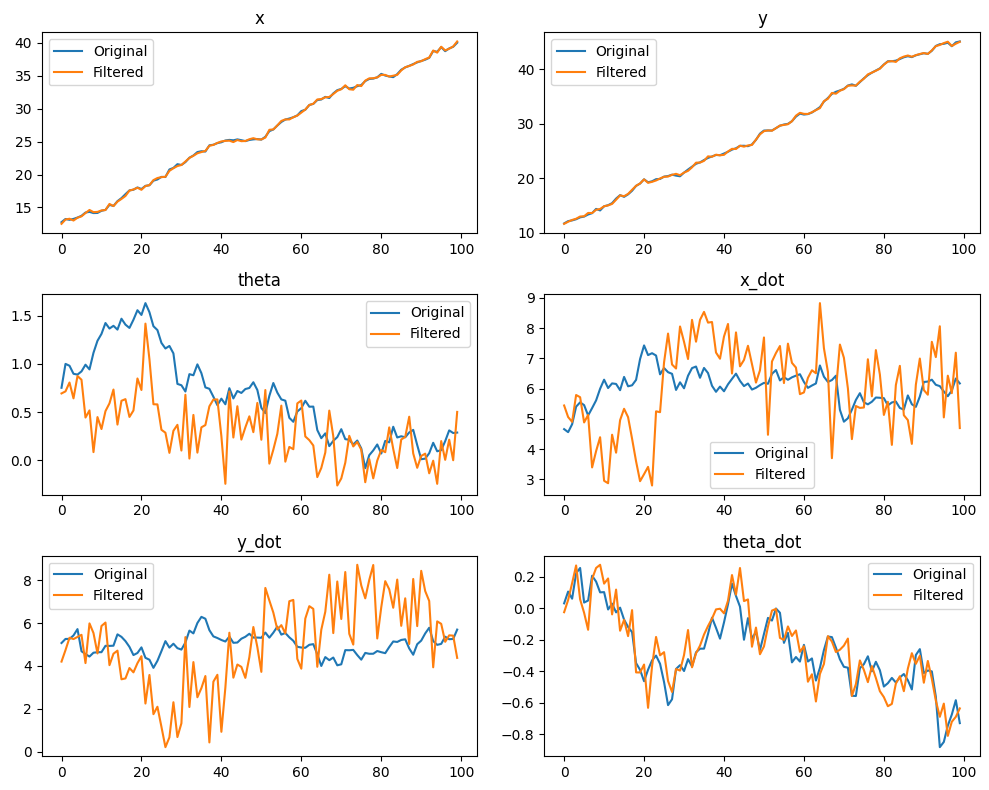

In [161]:
# Define the titles for each subplot
titles = ["x", "y", "theta", "x_dot", "y_dot", "theta_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(6):
    axes[i].plot(z[i, :], label='Original')
    axes[i].plot(z_filtered_array[i, :], label='Filtered')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [162]:
z_predicted_array = np.array(z_predicted)
z_predicted_array = z_predicted_array.T

In [163]:
for i in range(1,N+1):
    z_predicted_array[:,i] = generating_z_prediction(z_predicted_array[:,i], sigma_predicted[i]) 

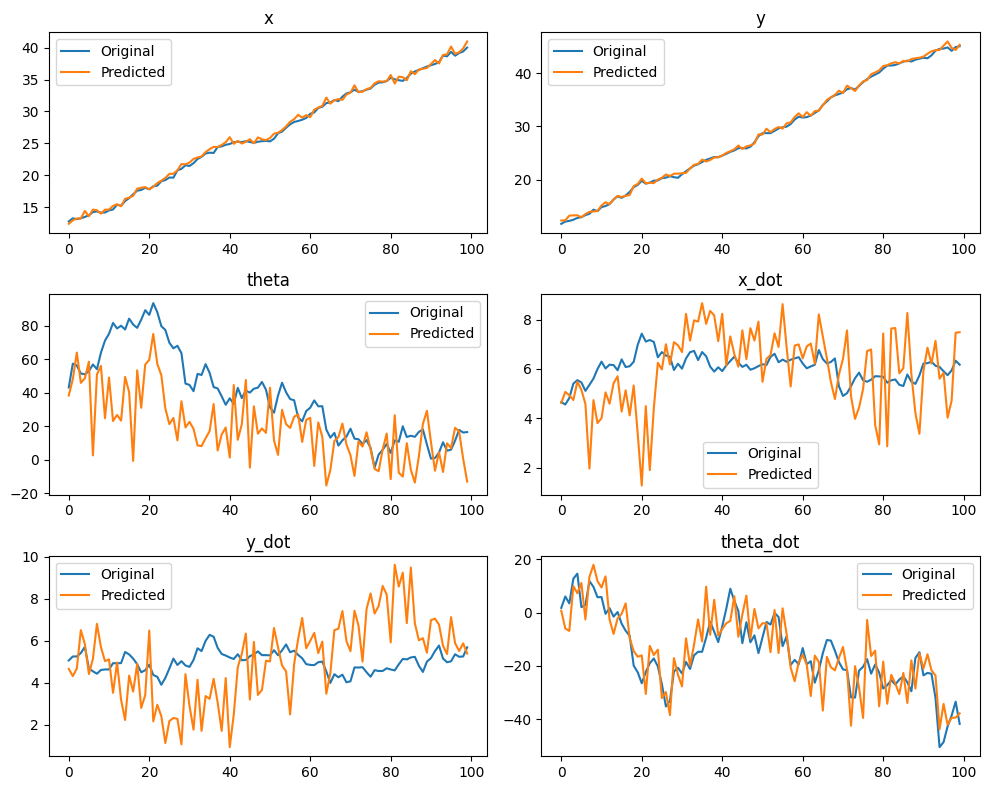

In [166]:
# Define the titles for each subplot
titles = ["x", "y", "theta", "x_dot", "y_dot", "theta_dot"]

# Create a figure and a set of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each row of z and z_filtered_array on its corresponding subplot
for i in range(6):
    gamma = 1
    if i == 2 or i == 5:
        gamma = 180/np.pi
    axes[i].plot(gamma*z[i, :], label='Original')
    axes[i].plot(gamma*z_predicted_array[i, 1:], label='Predicted')
    axes[i].set_title(titles[i])
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

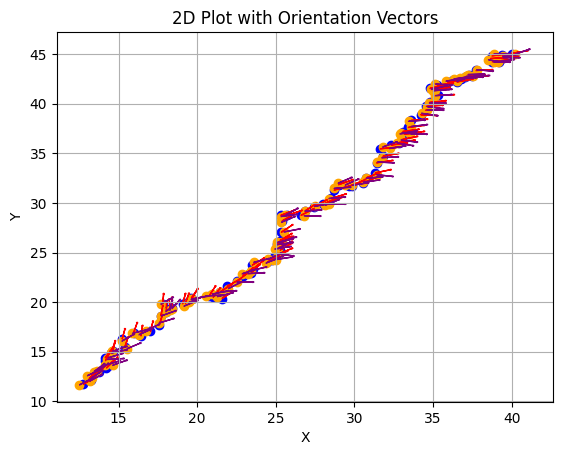

In [194]:
# Extract x, y, and theta from the data
x_coords = z[0,:]
y_coords = z[1,:]
thetas = z[2,:]

x_coords_filtered = z_filtered_array[0,:]
y_coords_filtered = z_filtered_array[1,:]
thetas_filtered = z_filtered_array[2,:]


# Plot the points
plt.figure()
plt.scatter(x_coords, y_coords, color='blue')
plt.scatter(x_coords_filtered, y_coords_filtered, color='orange')

# Draw the orientation vectors
for x, y, theta in zip(x_coords, y_coords, thetas):
    dx = np.cos(theta)
    dy = np.sin(theta)
    plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

for x, y, theta in zip(x_coords_filtered, y_coords_filtered, thetas_filtered):
    dx = np.cos(theta)
    dy = np.sin(theta)
    plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='purple', ec='purple')


# Set plot labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot with Orientation Vectors')
plt.grid(True)

# Show the plot
plt.show()

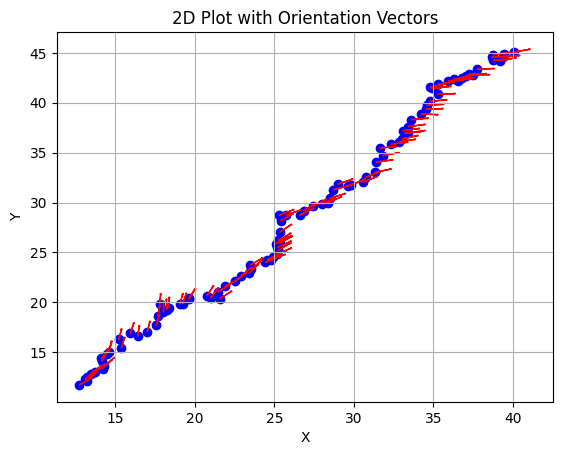

In [195]:
# Extract x, y, and theta from the data
x_coords = z[0,:]
y_coords = z[1,:]
thetas = z[2,:]

# Plot the points
plt.figure()
plt.scatter(x_coords, y_coords, color='blue')

# Draw the orientation vectors
for x, y, theta in zip(x_coords, y_coords, thetas):
    dx = np.cos(theta)
    dy = np.sin(theta)
    plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

# Set plot labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot with Orientation Vectors')
plt.grid(True)

# Show the plot
plt.show()

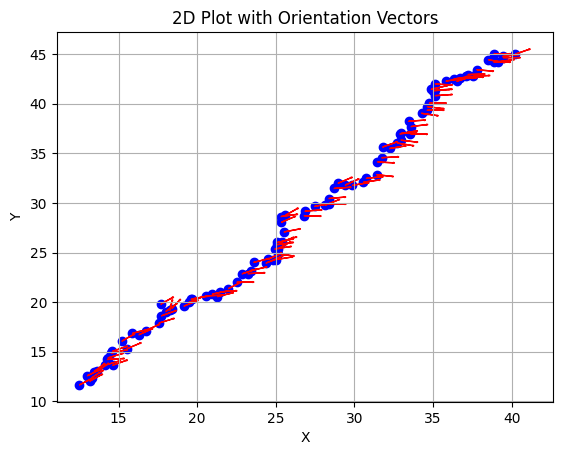

In [192]:
# Extract x, y, and theta from the data
x_coords = z_filtered_array[0,:]
y_coords = z_filtered_array[1,:]
thetas = z_filtered_array[2,:]

# Plot the points
plt.figure()
plt.scatter(x_coords, y_coords, color='blue')

# Draw the orientation vectors
for x, y, theta in zip(x_coords, y_coords, thetas):
    dx = np.cos(theta)
    dy = np.sin(theta)
    plt.arrow(x, y, dx, dy, head_width=0.1, head_length=0.1, fc='red', ec='red')

# Set plot labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Plot with Orientation Vectors')
plt.grid(True)

# Show the plot
plt.show()